##### ASakai
https://github.com/AtsushiSakai/PythonRobotics/blob/master/Localization/extended_kalman_filter/extended_kalman_filter_localization.ipynb

##### RLabbe
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

In [1]:
import os
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

In [2]:
file_path = os.path.join(os.getcwd(), 'data')
drive_file = 'drive_data_200703.json'
message_file = 'drive_messages_200703.json'

def load_json_fstr(fstr):
    with open(os.path.join(file_path, fstr), 'r') as f:
        res = json.load(f)
    return res

drive_data = load_json_fstr(drive_file)
message_data = load_json_fstr(message_file)

In [3]:
pprint(drive_data)
pprint(message_data)

[{'nu_control': 0.0,
  'nu_sensor': 0.30763775945094907,
  'omega_control': 0.0,
  'omega_sensor': -0.0032724923474893677,
  't': 1593807527.350696,
  'theta_control': 0.0,
  'theta_sensor': -5.459826232551261e-05,
  'x_control': 0.0,
  'x_sensor': 0.005132628376129599,
  'y_control': 0.0,
  'y_sensor': -1.401162900753114e-07},
 {'nu_control': 5.847775412992804,
  'nu_sensor': 12.812986252678105,
  'omega_control': 0.0,
  'omega_sensor': -0.0032724923474893677,
  't': 1593807527.429632,
  'theta_control': 0.0,
  'theta_sensor': -0.0003129157182669333,
  'x_control': 0.0,
  'x_sensor': 1.0165384913296018,
  'y_control': 0.0,
  'y_sensor': -0.00018599301606192901},
 {'nu_control': 14.716140950700341,
  'nu_sensor': 18.71036964767183,
  'omega_control': 0.043748289300719126,
  'omega_sensor': 0.014180800172453928,
  't': 1593807527.502168,
  'theta_control': 0.0031733259127169626,
  'theta_sensor': 0.0007157028030421848,
  'x_control': 60.82396459145406,
  'x_sensor': 2.373713776738062,
 

  'omega_sensor': 1.4748032179352084,
  't': 1593807530.450237,
  'theta_control': 1.1709572617925597,
  'theta_sensor': 1.3962666271820874,
  'x_control': 653.0034688757579,
  'x_sensor': 79.86574200933283,
  'y_control': 341.67302626653384,
  'y_sensor': 84.89398887900931},
 {'nu_control': 0.0,
  'nu_sensor': 33.68440844766852,
  'omega_control': 1.8123674286312357,
  'omega_sensor': 2.1805707342104155,
  't': 1593807530.523776,
  'theta_control': 1.3042369501266722,
  'theta_sensor': 1.5566236184051871,
  'x_control': 653.0034688757579,
  'x_sensor': 80.09886447303558,
  'y_control': 341.67302626653384,
  'y_sensor': 87.35744752354157},
 {'nu_control': 0.3932232035764911,
  'nu_sensor': 32.871607710264314,
  'omega_control': 1.859843722696944,
  'omega_sensor': 2.705260340591211,
  't': 1593807530.597144,
  'theta_control': 1.4406899643735016,
  'theta_sensor': 1.7551031590736832,
  'x_control': 652.8624654309325,
  'x_sensor': 79.89428971336233,
  'y_control': 341.9305563628731,
  

  'theta_control': 2.015061954575272,
  'theta_sensor': 2.494424928015285,
  'x_control': 562.3550496119311,
  'x_sensor': 26.232786970165417,
  'y_control': 873.6920579217742,
  'y_sensor': 168.245002560849},
 {'nu_control': 0.0,
  'nu_sensor': 43.90265088784418,
  'omega_control': 0.0,
  'omega_sensor': -0.0,
  't': 1593807532.813845,
  'theta_control': 2.015061954575272,
  'theta_sensor': 2.494424928015285,
  'x_control': 562.3550496119311,
  'x_sensor': 26.232786970165417,
  'y_control': 873.6920579217742,
  'y_sensor': 168.245002560849},
 {'nu_control': 0.0,
  'nu_sensor': 44.79376243771251,
  'omega_control': 0.0,
  'omega_sensor': -0.0,
  't': 1593807532.887743,
  'theta_control': 2.015061954575272,
  'theta_sensor': 2.494424928015285,
  'x_control': 562.3550496119311,
  'x_sensor': 26.232786970165417,
  'y_control': 873.6920579217742,
  'y_sensor': 168.245002560849},
 {'nu_control': 0.0,
  'nu_sensor': 45.867345352799305,
  'omega_control': 0.0,
  'omega_sensor': -0.00109083078

Set Initial Conditions

In [36]:
prior_dat = {
    't': drive_data[0].get('t'),
    'x_control': 0,
    'y_control': 0, 
    'x_sensor': 0,
    'y_sensor': 0,
    'theta_control': drive_data[0].get('theta_control'),
    'theta_sensor': drive_data[0].get('theta_control')
}

x_true = np.array([0, 0, drive_data[0].get('theta_control')])

F = np.identity(3)
P = np.identity(3)
H = np.identity(3)
Q = np.zeros([3,3])
R = np.zeros([3,3])

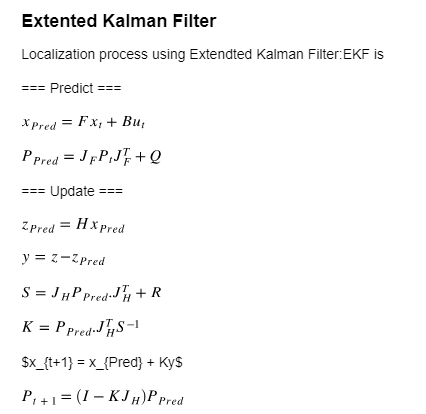

In [37]:
for i, curr_dat in enumerate(drive_data, 1):
    dt = curr_dat['t'] - prior_dat['t']
    u_t_control = np.array(
        [curr_dat['x_control'] - prior_dat['x_control'],
         curr_dat['y_control'] - prior_dat['y_control'],
         curr_dat['theta_control'] - prior_dat['theta_control']])
    
    u_t_sensor = np.array(
        [curr_dat['x_sensor'] - prior_dat['x_sensor'],
         curr_dat['y_sensor'] - prior_dat['y_sensor'],
         curr_dat['theta_sensor'] - prior_dat['theta_sensor']])
    
    r_control = curr_dat['nu_control'] / curr_dat['omega_control'] if curr_dat['omega_control'] > 10e-6 else 10e-6
    J_control = np.array([
        [1, 0, r_control * (-np.cos(x_true[2]) + np.cos(x_true[2] + dt * curr_dat['omega_control']))],
        [0, 1, r_control * (np.sin(x_true[2]) + np.sin(x_true[2] + dt * curr_dat['omega_control']))],
        [0, 0, 1]
    ])
    
    r_sensor = curr_dat['nu_sensor'] / curr_dat['omega_sensor'] if curr_dat['omega_sensor'] > 10e-6 else 10e-6
    J_sensor = np.array([
        [1, 0, r_sensor * (-np.cos(x_true[2]) + np.cos(x_true[2] + dt * curr_dat['omega_sensor'])) ],
        [0, 1, r_sensor * (np.sin(x_true[2]) + np.sin(x_true[2] + dt * curr_dat['omega_sensor']))],
        [0, 0, 1]
    ])
    
        # What to plugin to alpha 1-4?
    alpha_1, alpha_2, alpha_3, alpha_4 = 10e-7, 15e-7, 5e-7, 20e-7
    alpha_1, alpha_2, alpha_3, alpha_4 = (10,) * 4
    qalpha_1, qalpha_2, qalpha_3, qalpha_4 = (1,) * 4
    
    R_t_1_1 = alpha_1 * curr_dat['nu_sensor']**2 + alpha_2 * curr_dat['omega_sensor']**2
    R_t_2_2 = alpha_3 * curr_dat['nu_sensor']**2 + alpha_4 * curr_dat['omega_sensor']**2
    R = np.array([
        [R_t_1_1, 0, 0],
        [0, R_t_2_2, 0],
        [0, 0, 1]
    ])
    
    Q_t_1_1 = qalpha_1 * curr_dat['nu_control']**2 + qalpha_2 * curr_dat['omega_control']**2
    Q_t_2_2 = qalpha_3 * curr_dat['nu_control']**2 + qalpha_4 * curr_dat['omega_control']**2
    Q = np.array([
        [Q_t_1_1, 0, 0],
        [0, Q_t_2_2, 0],
        [0, 0, 1]
    ])
    
    # === Predict ===
    x_pred_control = x_true + u_t_control
    x_pred_sensor = x_true + u_t_sensor
    P_pred = J_control.dot(P).dot(J_control.T) + Q
    # === Update ===
    z_pred_control = H.dot(x_pred_control)
    z_pred_sensor = H.dot(x_pred_sensor)
    y = z_pred_sensor - z_pred_control
    S = J_sensor.dot(P_pred).dot(J_sensor.T) + R
    K = P_pred.dot(J_sensor.T).dot(np.linalg.inv(S))
    x_true = x_pred_control + K.dot(y)
    
    # Review
    print(
        f"x_true: {x_true}"
        # f"\nP {P}"
        f"\ny: {y}"
        f"\n"
    )
    # Setup for Next Iteration
    curr_dat['x_true'] = x_true[0]
    curr_dat['y_true'] = x_true[1]
    prior_dat = curr_dat
        

x_true: [ 2.63682689e-03 -7.19830805e-08 -3.63988416e-05]
y: [ 5.13262838e-03 -1.40116290e-07 -5.45982623e-05]

x_true: [ 2.38649505e-02 -3.97279919e-06 -2.08610479e-04]
y: [ 1.01140586e+00 -1.85852900e-04 -2.58317456e-04]

x_true: [5.73683317e+01 5.21867941e+00 2.85384982e-04]
y: [-5.94667893e+01 -5.54446117e+00 -2.14470739e-03]

x_true: [ 5.74515807e+01  5.21858021e+00 -2.25773427e-03]
y: [ 1.85481258 -0.00221026 -0.00381468]

x_true: [ 1.27541925e+02  1.18237923e+01 -1.51769628e-03]
y: [-7.22236220e+01 -6.98435054e+00 -3.96129844e-03]

x_true: [ 1.27633186e+02  1.18229520e+01 -8.61139067e-03]
y: [ 1.83937893 -0.01693604 -0.01064054]

x_true: [ 1.27713685e+02  1.18226056e+01 -3.55986570e-03]
y: [ 1.92375043 -0.02066452  0.00757223]

x_true: [ 1.95290263e+02  1.84084839e+01 -3.97773140e-03]
y: [-6.88258753e+01 -6.90776995e+00 -6.18751826e-03]

x_true: [ 2.63629750e+02  1.28395819e+01 -7.72777533e-04]
y: [-6.86830662e+01  5.75697728e+00  9.84633596e-03]

x_true: [ 2.63663659e+02  1.283

In [15]:
print(drive_data[-1])

{'y_sensor': 229.12670625978004, 'omega_control': 0.0, 'theta_control': 2.015061954575272, 'nu_control': 0.0, 'y_control': 873.6920579217742, 'x_control': 562.3550496119311, 'omega_sensor': -0.004363323129985824, 'nu_sensor': 93.3634415183401, 't': 1593807534.653601, 'x_sensor': -54.22435724569855, 'theta_sensor': 2.4935312256268163, 'x_true': -52.918110814965885, 'y_true': 68.6578309184061}


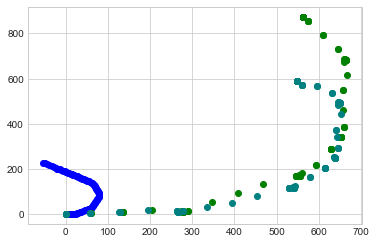

In [38]:
x_sensor = [dat.get('x_sensor') for dat in drive_data]
y_sensor = [dat.get('y_sensor') for dat in drive_data]
x_control = [dat.get('x_control') for dat in drive_data]
y_control = [dat.get('y_control') for dat in drive_data]
x_true = [dat.get('x_true') for dat in drive_data]
y_true = [dat.get('y_true') for dat in drive_data]

fig = plt.figure()
plt.plot(x_sensor, y_sensor, 'o', color='blue')
plt.plot(x_control, y_control, 'o', color='green')
plt.plot(x_true, y_true, 'o', color='teal')
plt.show()
# fig.savefig('plot.png')

In [26]:
print(K.dot(y))

[-5.40779537e+00  4.09316409e+00 -3.16964882e-04]


In [27]:
print(K)

[[ 1.00000000e+00  1.26217745e-29 -1.91293374e-09]
 [ 0.00000000e+00  1.00000000e+00 -1.20703128e-05]
 [ 0.00000000e+00 -6.77626358e-21  1.00000000e+00]]


In [10]:
R = np.zeros([3,3])
print(R)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
